In [37]:
import json
from pathlib import Path

import astropy.uncertainty as unc
import astropy.units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.modeling.models import Linear1D, Gaussian1D, Const1D
from astropy.modeling.fitting import LMLSQFitter, TRFLSQFitter
from astropy.time import Time

from feadme.parser import Template, Parameter, Line, Shape, Disk, Mask

finfo = np.finfo(float)

In [38]:
disk_profile = Disk(
    name="halpha_disk",
    center=Parameter(name="center", distribution="normal", low=6562.819 - 5, high=6562.819 + 5, loc=6562.819, scale=1),
    inner_radius=Parameter(name="inner_radius", distribution="log_uniform", low=1e2, high=5e3),
    delta_radius=Parameter(name="delta_radius", distribution="log_uniform", low=5e2, high=1e4),
    inclination=Parameter(name="inclination", distribution="normal", low=0, high=np.pi / 2, loc=np.pi / 4, scale=np.pi / 8),
    sigma=Parameter(name="sigma", distribution="log_uniform", low=1e2, high=1e4),
    q=Parameter(name="q", distribution="uniform", low=0.5, high=4),
    eccentricity=Parameter(name="eccentricity", distribution="uniform", low=0, high=1),
    apocenter=Parameter(name="apocenter", distribution="normal", low=0, high=2 * np.pi, loc=np.pi, scale=np.pi / 4),
    scale=Parameter(name="scale", distribution="uniform", low=0, high=1),
    offset=Parameter(name="offset", distribution="uniform", low=0, high=0.05, fixed=True, value=0)
)

halpha_narrow_line = Line(
    name="halpha_narrow",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3),
)

halpha_broad_line = Line(
    name="halpha_broad",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6548, high=6568, loc=6562.819, scale=2, shared="halpha_disk"),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e3, high=2e4),
)

hei_narrow_line = Line(
    name="hei_narrow",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="normal", low=6673, high=6683, loc=6678, scale=2),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=5e3),
)

un_narrow_line = Line(
    name="unknown_narrow",
    profile=Shape.gaussian,
    center=Parameter(name="center", distribution="uniform", low=6225, high=6330),
    amplitude=Parameter(name="amplitude", distribution="uniform", low=0, high=1),
    vel_width=Parameter(name="vel_width", distribution="log_uniform", low=1e1, high=1e4),
)

white_noise=Parameter(name="white_noise", distribution="uniform", low=-10, high=1)

In [39]:
Path.home() / Path("research/tde_agn_comparison/parsed")

PosixPath('/Users/nmearl/research/tde_agn_comparison/parsed')

Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not find 2018hyz
Could not find 2018zr
Could not find 09djl
Could not 

/var/folders/nh/szmvsy814lv8qrhs2cf18bqc0000gn/T/ipykernel_25746/1607516737.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(12, 4))


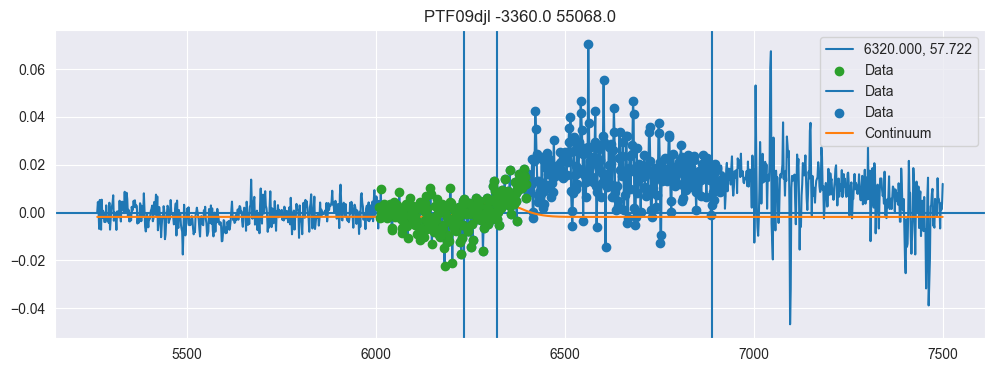

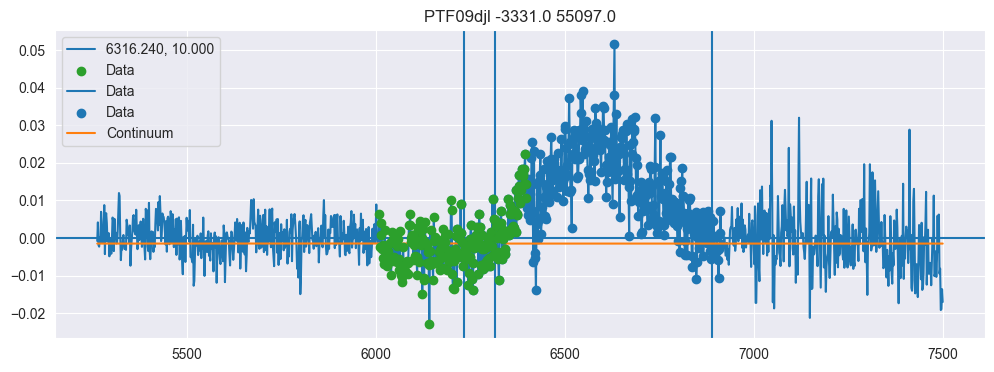

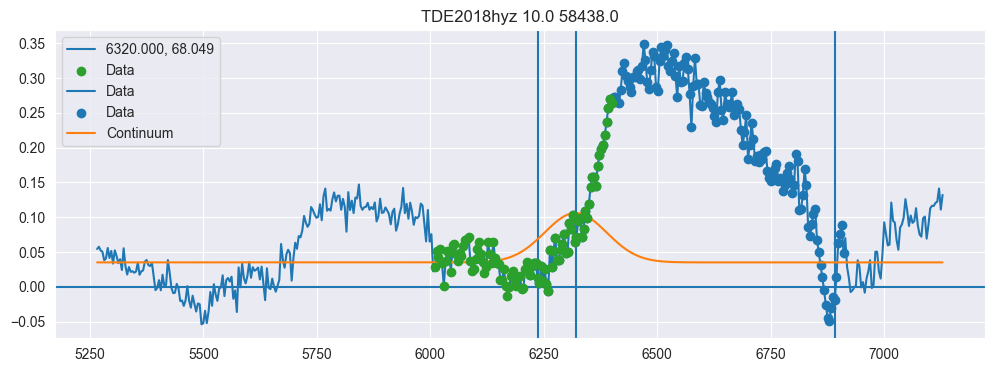

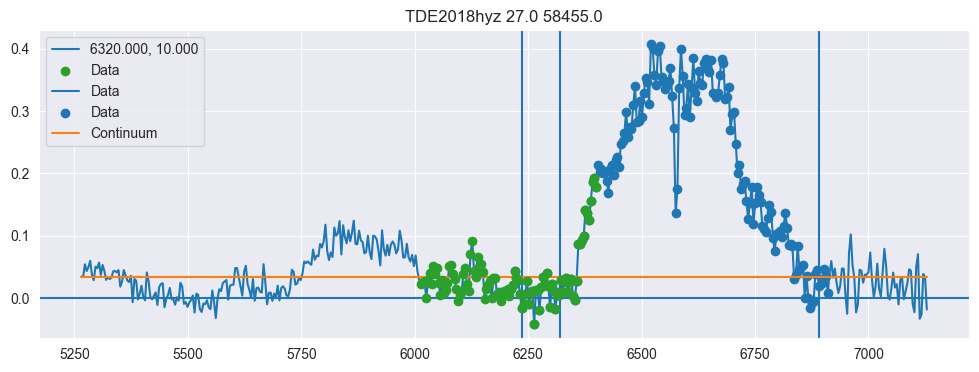

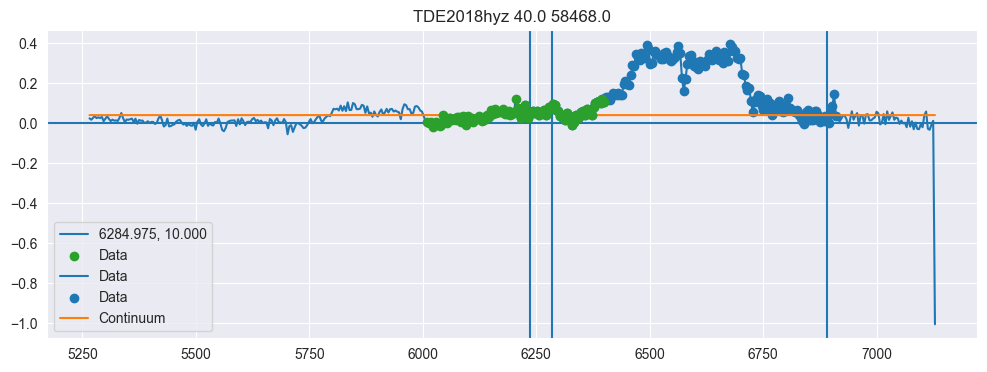

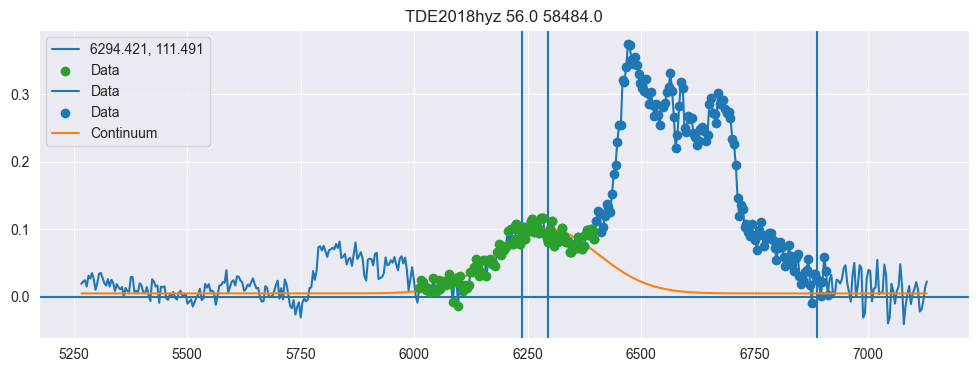

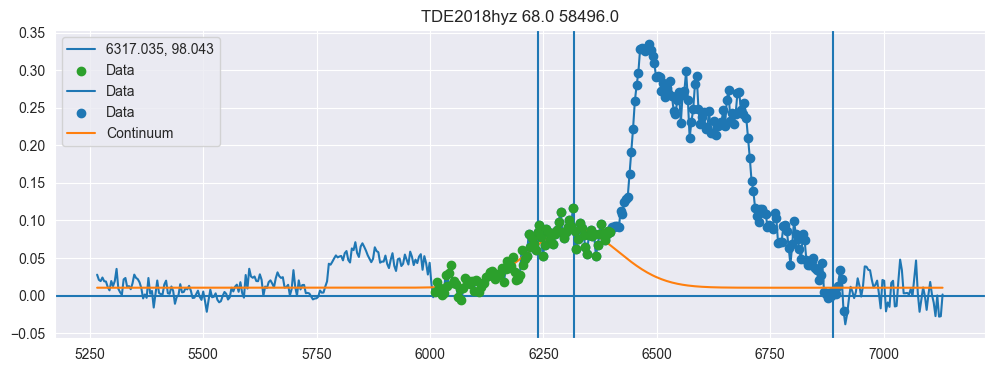

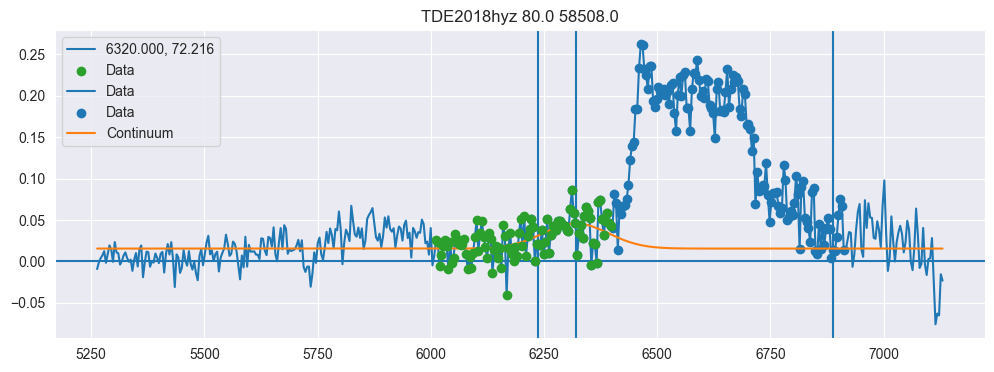

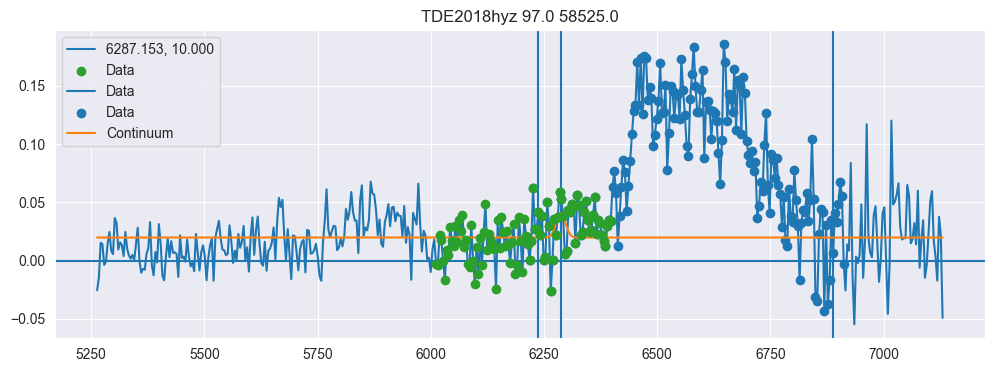

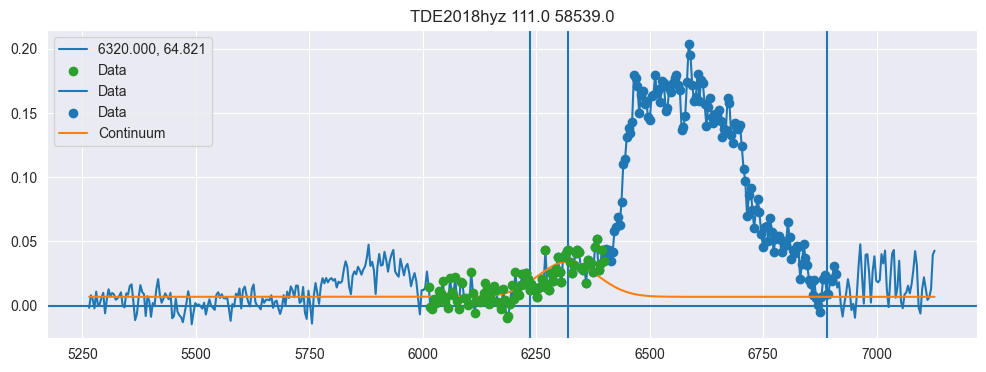

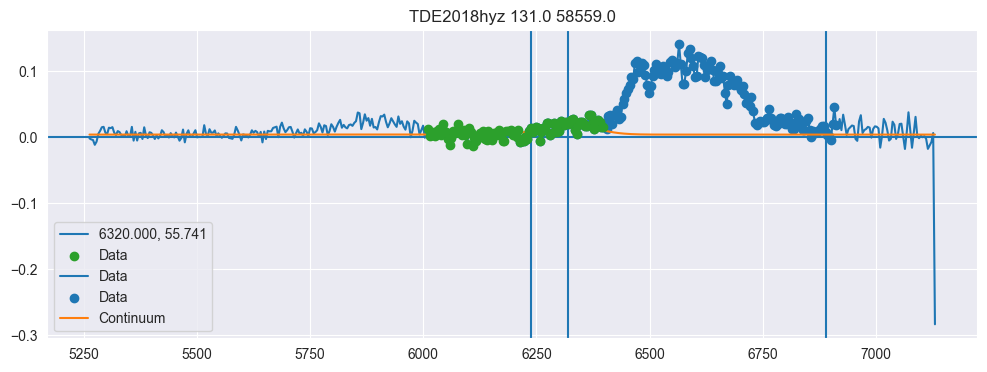

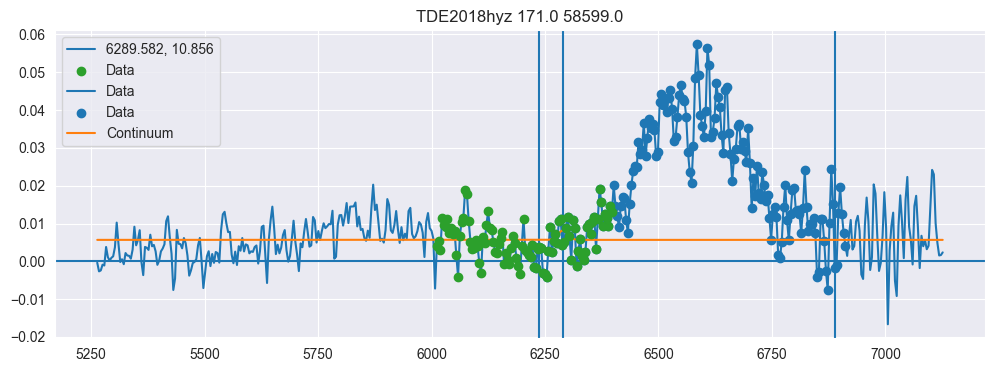

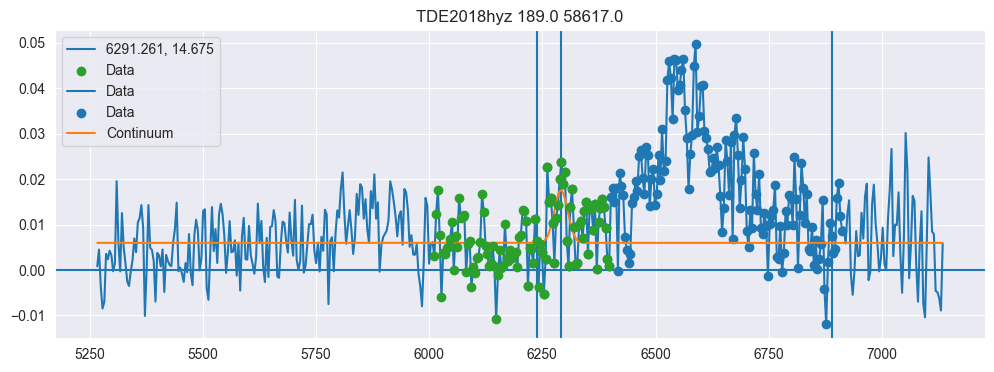

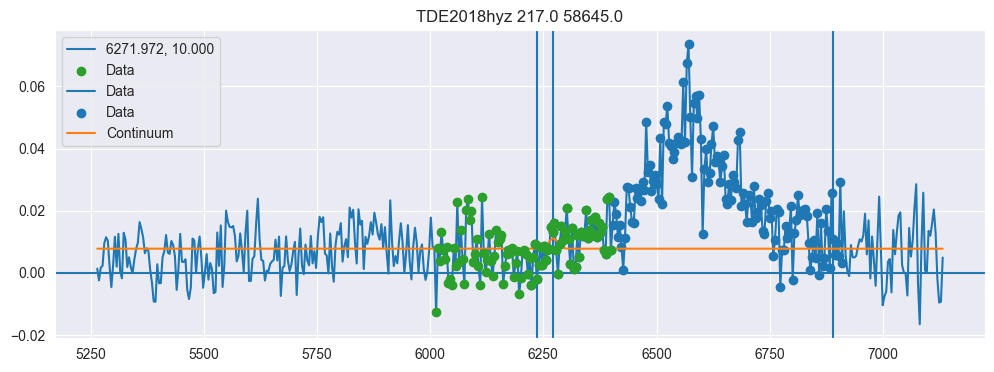

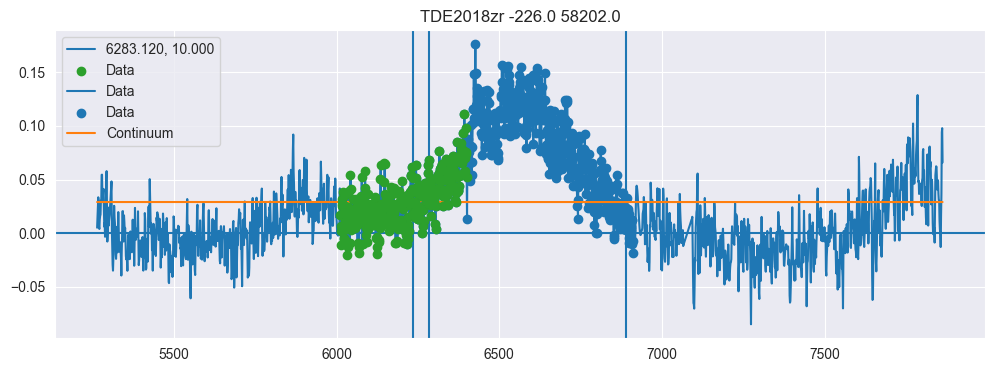

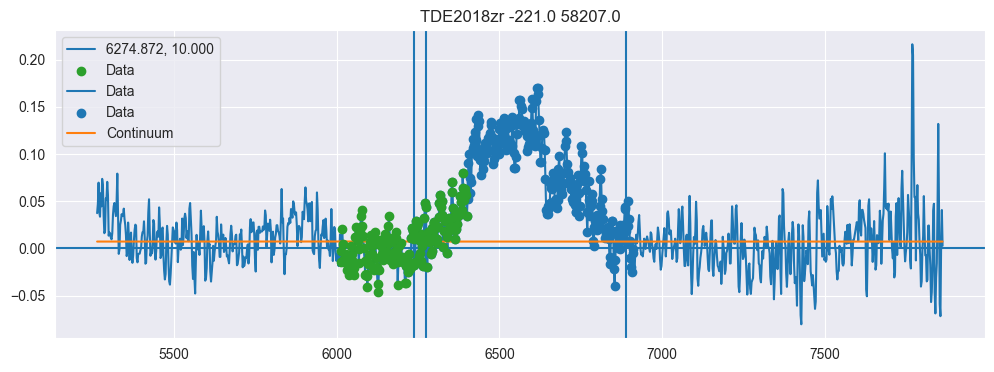

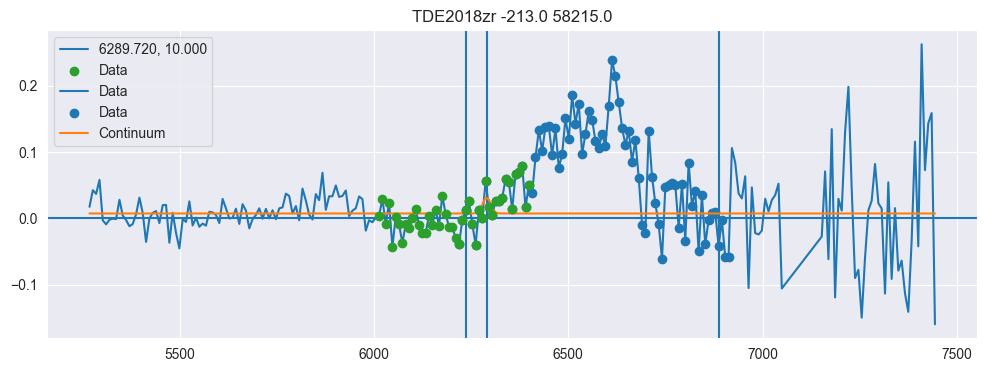

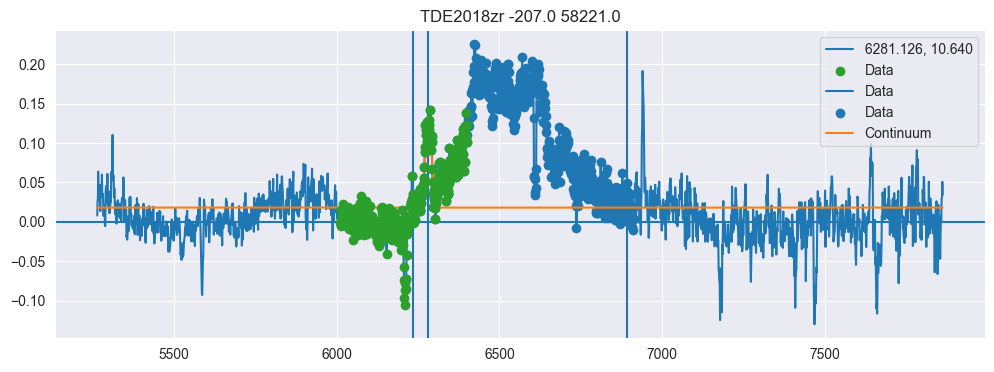

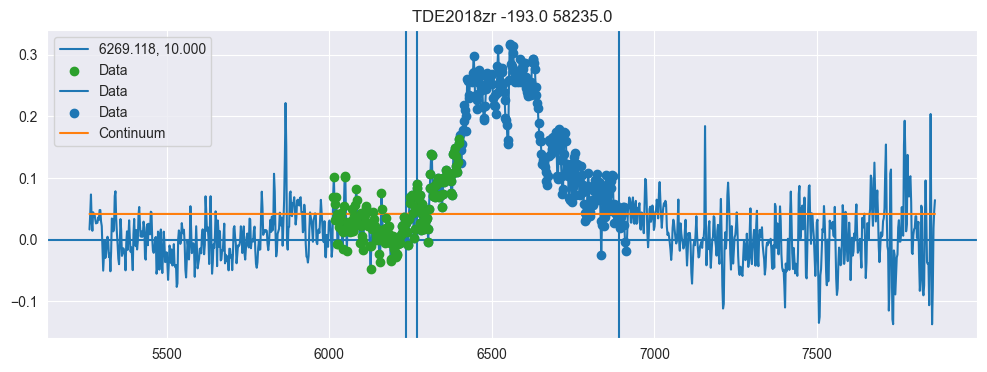

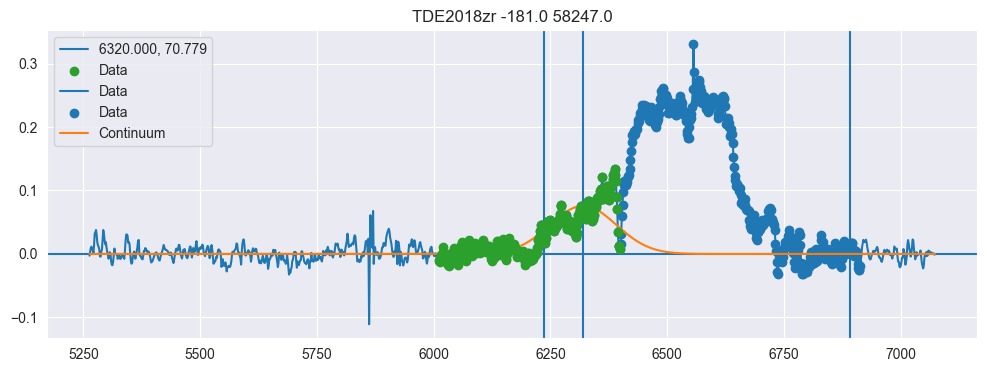

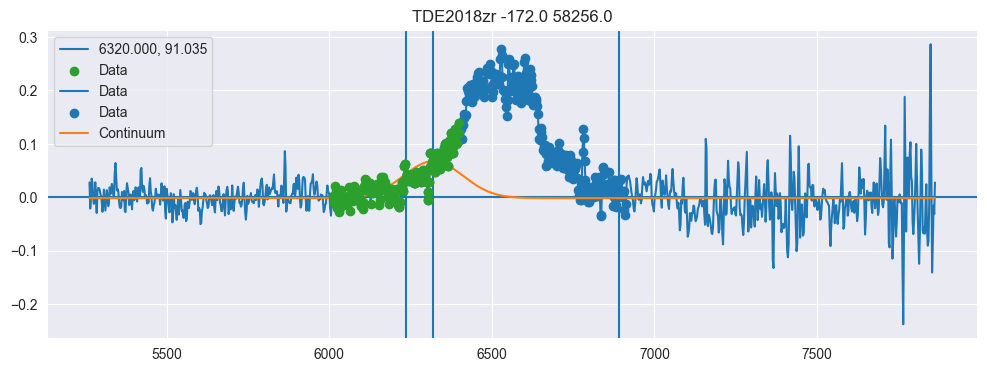

In [40]:
ingest_dir = Path.home() / Path("research/tde_agn_comparison/parsed")
output_dir = Path.home() / Path("research/tde_agn_comparison")

for file_path in sorted(ingest_dir.glob("*.ecsv")):
    for seg in ['2018hyz', '2018zr', '09djl']:#'14li', '2018hyz', '2018zr',]:#, '2020zso', '09djl']:
        if seg not in file_path.stem:
            print(f"Could not find {seg}")
            continue
    
        tab = Table.read(file_path, format='ascii.ecsv')
        label = tab.meta['name'].replace(',', '').replace(' ', '')
        redshift = tab.meta['redshift']
        mjd = tab.meta['obs_date']
        
        wave = tab['wave'] * u.AA
        flux = tab['flux'] * u.erg / u.s / u.cm ** 2 / u.AA
        flux_err = tab['uncertainty'] * u.erg / u.s / u.cm ** 2 / u.AA
        rest_wave = wave / (1 + redshift)
        rest_vel = rest_wave.to(u.km / u.s, u.doppler_optical(6563 * u.AA))
        vel_mask = (rest_vel.value >= -15e3) & (rest_vel.value <= +15e3)
        print(rest_vel)
        minw, maxw = np.min(rest_wave.value[vel_mask]), np.max(rest_wave.value[vel_mask])

        flux = flux.to(u.mJy, u.spectral_density(wave))
        flux_err = flux_err.to(u.mJy, u.spectral_density(wave))

        ha_mask = (rest_wave.value > 6563 - 350) & (rest_wave.value < 6563 + 350)
        full_mask = (rest_wave.value > 6563 - 650 * 2) & (rest_wave.value < 6563 + 650 * 2)
        part_mask = (rest_wave.value > 6563 - 300) & (rest_wave.value < 6563 + 300)
        cont_mask = full_mask & ~part_mask
        edge_mask = ((rest_wave.value > 6010) & (rest_wave.value < 6400))

        g = Gaussian1D(mean=6270, amplitude=0.5, stddev=15, bounds={"mean": (6270-25, 6270+50),
                                                                    "amplitude": (0, None),
                                                                    "stddev": (10, None)
                                                                     })
        fit_mod = TRFLSQFitter()(Const1D() + g, rest_wave[edge_mask], flux[edge_mask])

        cont_flux = fit_mod(rest_wave)
        # 
        fig, ax = plt.subplots(figsize=(12, 4))

        ax.axvline(fit_mod[1].mean.value, label=f"{fit_mod[1].mean.value:.3f}, {fit_mod[1].stddev.value:.3f}")
        ax.scatter(rest_wave[edge_mask], flux[edge_mask], label='Data', color='C2', zorder=10)
        ax.plot(rest_wave[full_mask], flux[full_mask], label='Data')
        ax.scatter(rest_wave[ha_mask], flux[ha_mask], label='Data')
        ax.axhline(0)
        ax.axvline(minw)
        ax.axvline(maxw)
        ax.set_title(f"{label} {mjd - 58428} {mjd}")
        ax.plot(rest_wave[full_mask], cont_flux[full_mask], label='Continuum')
        ax.legend()
        # 
        # flux -= cont_flux

        # ax.plot(rest_wave[full_mask], flux[full_mask], label='Continuum Subtracted')
        # ax.set_title(f"{label} {Time(mjd, format='mjd').iso}")
        
        # flux = flux[ha_mask]
        # flux_err = flux_err[ha_mask]
        # wave = wave[ha_mask]
    
        Table({'wave': wave, 'flux': flux, 'flux_err': flux_err}).write(
            output_dir / "data" / f"{label}_{mjd}.csv", format='ascii.csv', overwrite=True)
        
        template = Template(
            name=label,
            redshift=redshift,
            mjd=mjd,
            data_path=str(output_dir / "data" / f"{label}_{mjd}.csv"),
            # data_path=f"/datasets/transient-data/{label}_{mjd}.csv",
            disk_profiles=[
                disk_profile,
            ],
            line_profiles=[],
            white_noise=white_noise,
            mask=[Mask(lower_limit=6563 - 350, upper_limit=6563 + 350)]
        )
        
        if '2018zr' in seg:
            template.line_profiles=[
                halpha_broad_line,
            ]
        elif '2020zso' in seg:
            pass
        elif '2018hyz' in seg:
            template.line_profiles=[
                halpha_broad_line,
            ]
            if 58470 < mjd <= 58560:
                template.line_profiles.append(un_narrow_line)

        elif '14li' in seg:
            template.line_profiles=[
                # halpha_narrow_line,
                # halpha_broad_line,
                hei_narrow_line
            ]
        elif '09djl' in seg:
            template.line_profiles=[]
    
        for prof in template.disk_profiles:
            prof.scale.high = flux.max().value * 1.1
    
        for prof in template.line_profiles:
            prof.amplitude.high = flux.max().value * 1.1
    
        with open(output_dir / "templates" / f"{label}_{mjd}.json", "w") as f:
            json.dump(template.model_dump(), f, indent=4)